In [791]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv('titanic/train.csv', sep=',')


def convert_sex(sex):
    if(sex == 'male'):
        return 1
    else:
        return 0

data['SexBinary'] = data['Sex'].apply(convert_sex)


train = data

gender_submissions = pd.read_csv('titanic/gender_submission.csv', sep=',')

# 1. Load the test data
external_test_data = pd.read_csv('titanic/test.csv', sep=',')

# Convert Sex to binary
external_test_data['SexBinary'] = external_test_data['Sex'].apply(convert_sex)
external_test_data['Survived'] = gender_submissions['Survived']

test = external_test_data

print(train.shape, test.shape)




(891, 13) (418, 13)


In [792]:
print(train['Survived'].mean())
print(test['Survived'].mean())

0.3838383838383838
0.36363636363636365


In [793]:
def plot_auroc(truth, predictions):
    fpr, tpr, threshold = metrics.roc_curve(truth, predictions)
    roc_auc = metrics.auc(fpr, tpr)

    # method I: plt
    import matplotlib.pyplot as plt
    plt.title('Receiver Operating Characteristic')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [794]:
alwaysSurvive = pd.Series([1]).repeat(len(test))
neverSurvive = pd.Series([0]).repeat(len(test))
meanSurvive = pd.Series(test['Survived'].mean()).repeat(len(test))

In [795]:
import numpy as np
from sklearn import metrics

# Assuming you have your true labels (ground truth) and predicted probabilities
truth = test['Survived']  # True labels (0 for negative, 1 for positive)
prediction = alwaysSurvive  # Predicted probabilities of belonging to the positive class

# Calculate the AUC using the formula
fpr, tpr, thresholds = metrics.roc_curve(truth, prediction, pos_label=1)
auc_score = 0.0

# Using the trapezoidal rule to calculate AUC
for i in range(1, len(fpr)):
    auc_score += abs((tpr[i] + tpr[i - 1]) * (fpr[i - 1] - fpr[i])) / 2


print("fpr:", fpr)
print("tpr:", tpr)
print("AUC:", abs(auc_score))

fpr: [0. 1.]
tpr: [0. 1.]
AUC: 0.5


In [796]:
def compute_auroc(truth, prediction):
    fpr, tpr, thresholds = metrics.roc_curve(truth, prediction, pos_label=1)
    return metrics.auc(fpr, tpr)

1.0


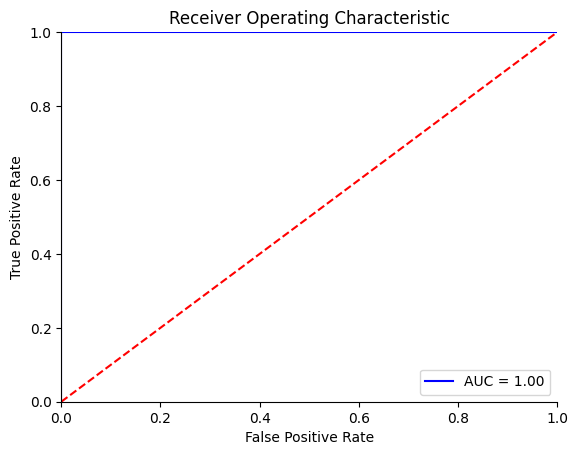

0.5


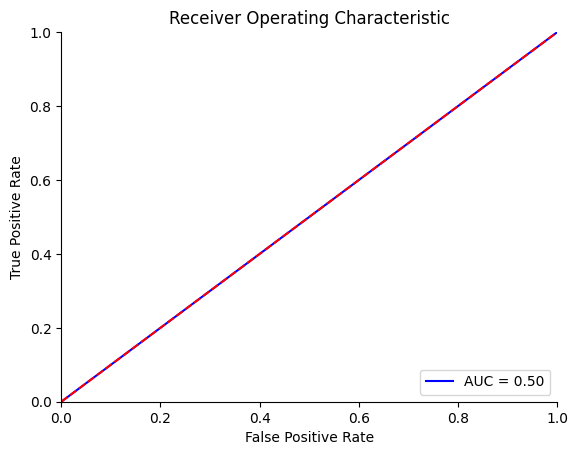

0.5


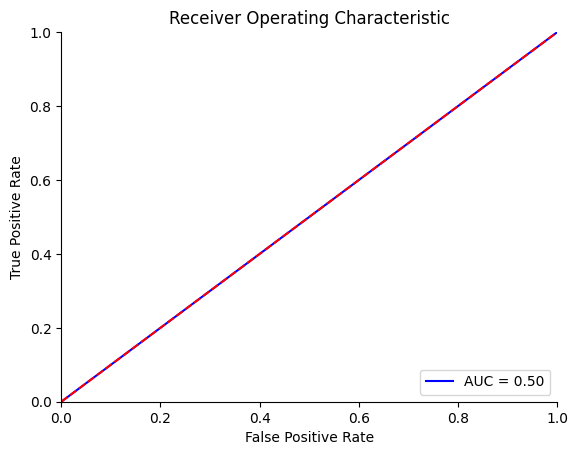

0.5


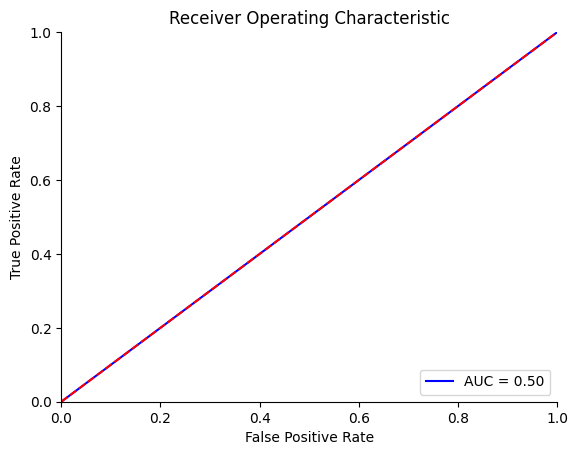

In [797]:
print(compute_auroc(test['Survived'], test['Survived']))
plot_auroc(test['Survived'], test['Survived'])
print(compute_auroc(test['Survived'], alwaysSurvive )) 
plot_auroc(test['Survived'], alwaysSurvive )
print(compute_auroc(test['Survived'], neverSurvive)) 
plot_auroc(test['Survived'], neverSurvive)
print(compute_auroc(test['Survived'], meanSurvive)) 
plot_auroc(test['Survived'], meanSurvive)

In [798]:
train.groupby("Pclass")['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

In [799]:
def model1(row):
    if row.Pclass == 1:
        return 0.639456
    elif row.Pclass == 2:
        return 0.453846
    elif row.Pclass == 3:
        return 0.248555
    else:
        return  0.3838383838383838# Mean value across the whole dataset.

In [800]:
predictions1 = test.apply(model1, axis=1)
predictions1.head()

0    0.248555
1    0.248555
2    0.453846
3    0.248555
4    0.248555
dtype: float64

In [801]:
predictions1.value_counts()

0.248555    218
0.639456    107
0.453846     93
Name: count, dtype: int64

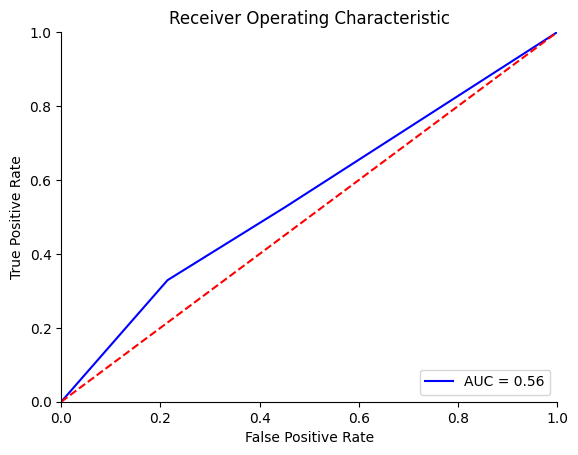

0.5554016620498614

In [802]:
plot_auroc(test['Survived'], predictions1)
compute_auroc(test['Survived'], predictions1)

In [803]:
featuresModel1 = ['Pclass'] 

In [804]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=10)
dt.fit(train[featuresModel1], train['Survived'])

DecisionTreeClassifier(max_depth=10)

In [805]:
def apply_model(model, features, validation_function = compute_auroc, print_to_screen = True, show_auroc = False):
    pred_tree_train = model.predict_proba(train[features])
    pred_tree_test = model.predict_proba(test[features])
    
    pred_churn_tree_train = pd.Series(map(lambda x: x[1], pred_tree_train))
    pred_churn_tree_test = pd.Series(map(lambda x: x[1], pred_tree_test))
    
    validation_result_train = validation_function(train['Survived'], pred_churn_tree_train) 
    validation_result_test = validation_function(test['Survived'], pred_churn_tree_test)
    
    if(print_to_screen):
        print( "Result on trainset:" )
        print( validation_result_train )
        print()
        print( "Result on testset:" )
        print( validation_result_test )
    if(show_auroc):
        plot_auroc(test['Survived'], pred_churn_tree_test)
    
    return (validation_result_train, validation_result_test)

Result on trainset:
0.6814170368239968

Result on testset:
0.5554016620498614


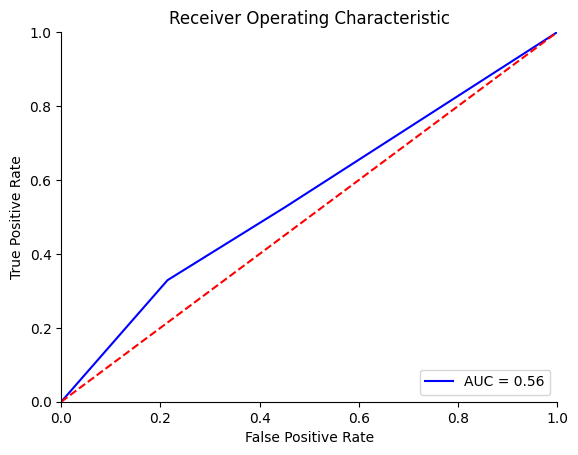

(0.6814170368239968, 0.5554016620498614)

In [806]:
apply_model(dt, featuresModel1, show_auroc=True)

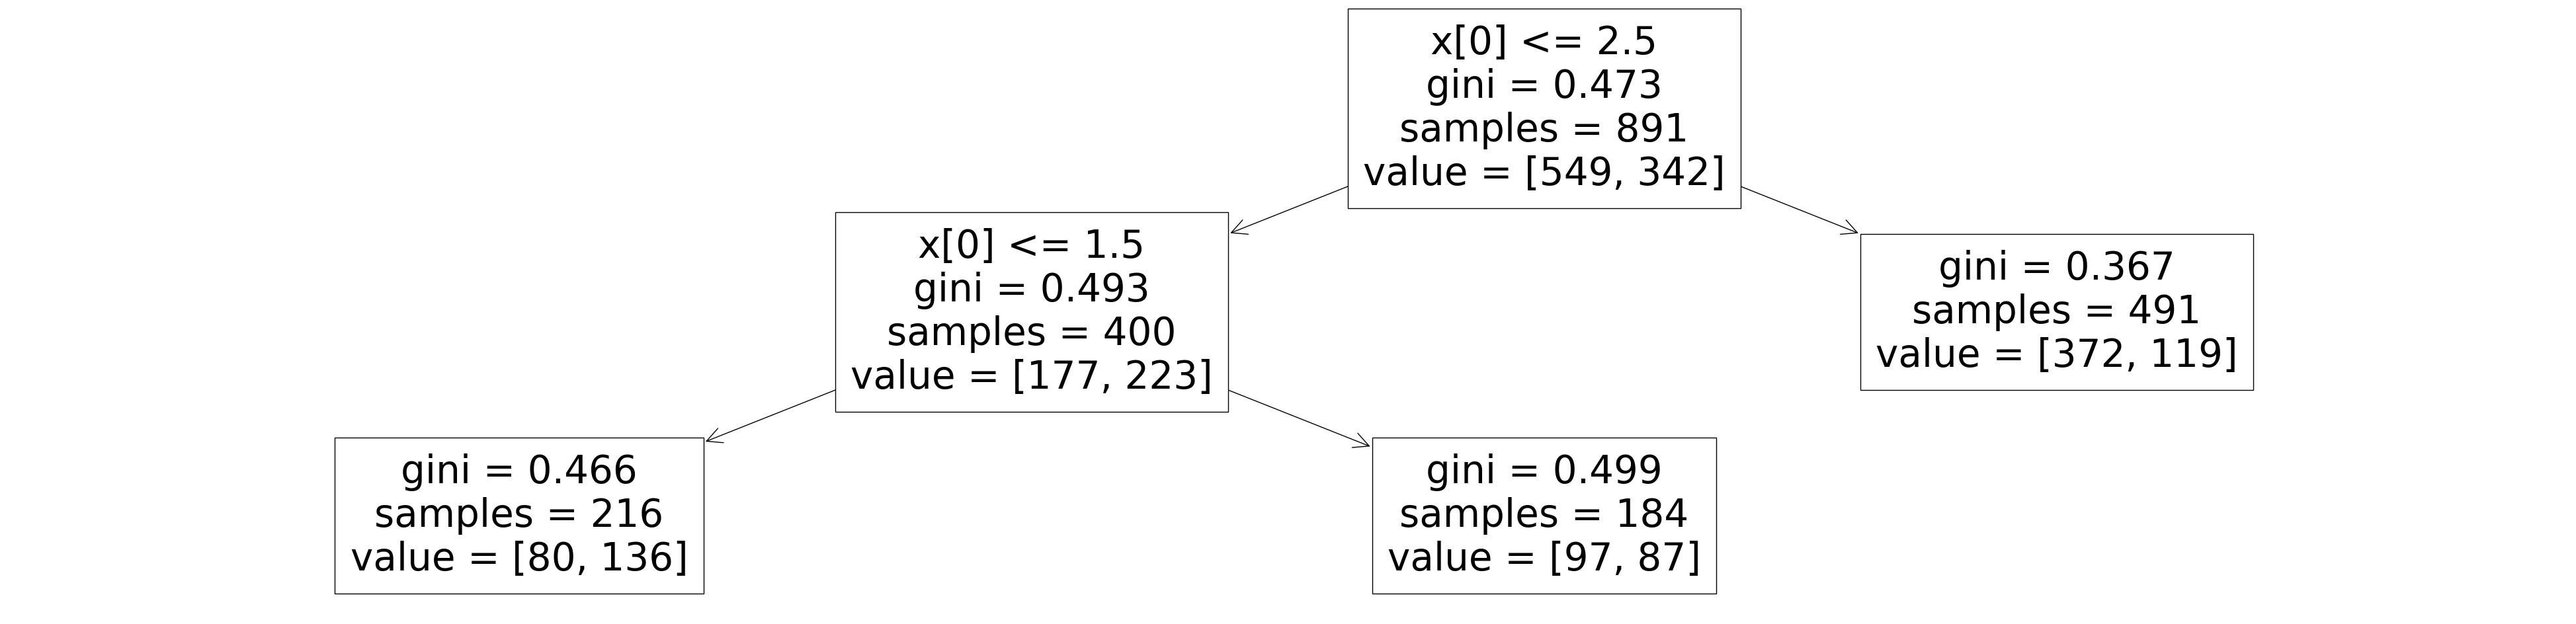

In [807]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(50,12))
plot_tree(dt)
plt.show()

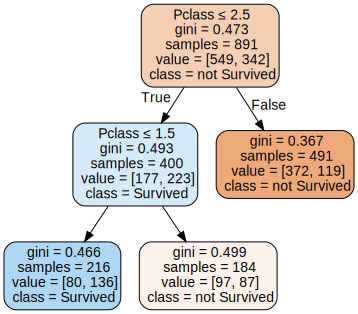

In [808]:
from sklearn import tree
import graphviz

def plot_tree(model, features):
    # Generate plot data
    dot_data = tree.export_graphviz(model, out_file=None, 
                          feature_names=features,  
                          class_names=['not Survived', 'Survived'],  
                          filled=True, rounded=True,  
                          special_characters=True)  

    # Turn into graph using graphviz
    graph = graphviz.Source(dot_data)  

    # Write out a pdf
    graph.render("decision_tree")

    # Display in the notebook
    return graph 

plot_tree(dt, featuresModel1)

In [809]:

featuresModel2 = ['Pclass', 'SexBinary']
dt2 = DecisionTreeClassifier()
dt2.fit(train[featuresModel2], train['Survived'])

DecisionTreeClassifier()

In [810]:
apply_model(dt2, featuresModel2)

Result on trainset:
0.8328353518891338

Result on testset:
1.0


(0.8328353518891338, 1.0)

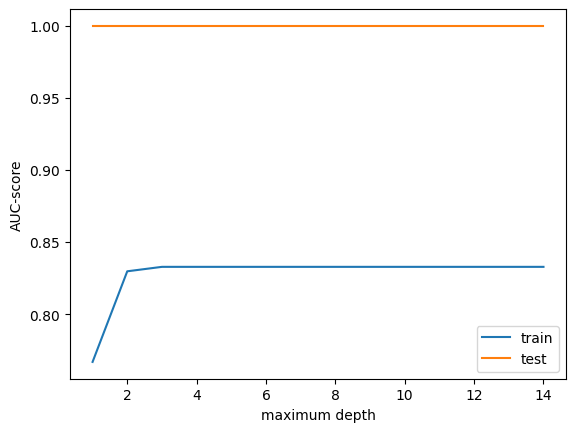

In [811]:
err_train = []
err_test = []
depths = range(1, 15)

for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(train[featuresModel2], train['Survived'])
    err_train_i, err_test_i = apply_model(dt, featuresModel2, print_to_screen=False)
    err_train.append(err_train_i)
    err_test.append(err_test_i)
    
plt.plot(depths, err_train, label='train')
plt.plot(depths, err_test, label='test')
plt.legend()
plt.xlabel('maximum depth')
plt.ylabel('AUC-score')
plt.show()

In [812]:
dt3 = DecisionTreeClassifier(max_depth=6)
dt3.fit(train[featuresModel2], train['Survived'])

DecisionTreeClassifier(max_depth=6)

In [813]:
apply_model(dt3, featuresModel2)

Result on trainset:
0.8328353518891338

Result on testset:
1.0


(0.8328353518891338, 1.0)

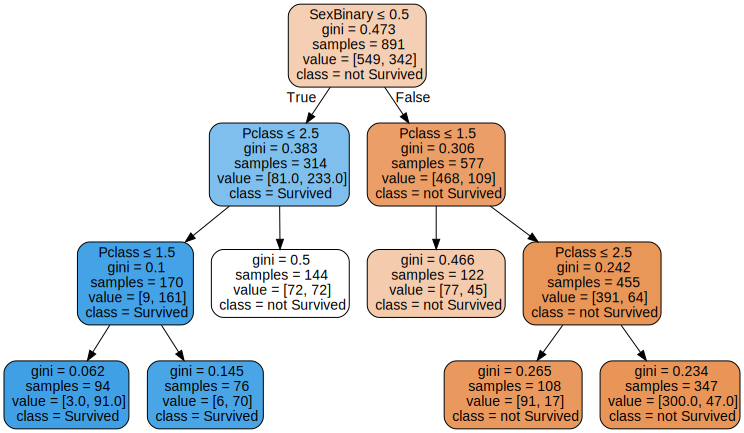

In [814]:
plot_tree(dt3, featuresModel2)

In [815]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexBinary'],
      dtype='object')

Result on trainset:
0.9972650965604661

Result on testset:
0.8935743965176097


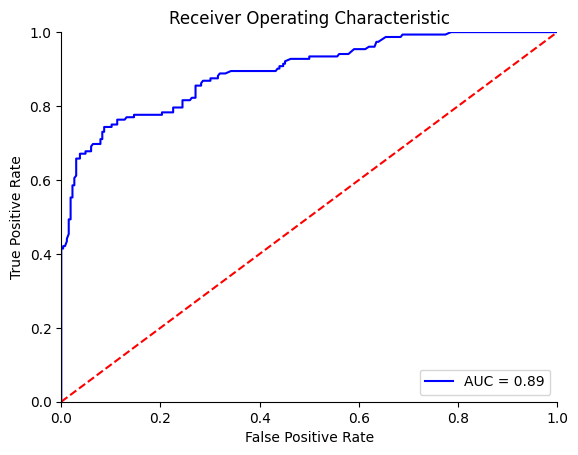

(0.9972650965604661, 0.8935743965176097)

In [816]:
from sklearn.ensemble import RandomForestClassifier

featuresModelRF = ['Pclass','SexBinary', 'Age', 'Parch', 'Fare'] 
forest = RandomForestClassifier(n_estimators=200, random_state = 123)
forest.fit(train[featuresModelRF], train['Survived'])

apply_model(forest, featuresModelRF, show_auroc=True)

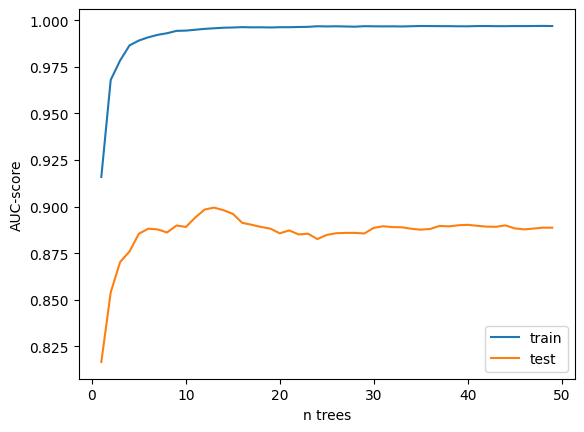

In [817]:
AUC_train = []
AUC_test = []
n_trees = range(1, 50)

for n_tree in n_trees:
    rf = RandomForestClassifier(n_estimators=n_tree, random_state = 123)
    rf.fit(train[featuresModelRF], train['Survived'])
    AUC_train_i, AUC_test_i = apply_model(rf, featuresModelRF, print_to_screen=False)
    AUC_train.append(AUC_train_i)
    AUC_test.append(AUC_test_i)
    
plt.plot(n_trees, AUC_train, label='train')
plt.plot(n_trees, AUC_test, label='test')
plt.legend()
plt.xlabel('n trees')
plt.ylabel('AUC-score')
plt.show()

In [818]:
forest.feature_importances_

array([0.09334223, 0.27267289, 0.27634618, 0.038492  , 0.31914671])

Feature ranking:
1. feature 4 Pclass (0.319147)
2. feature 2 SexBinary (0.276346)
3. feature 1 Age (0.272673)
4. feature 0 Parch (0.093342)
5. feature 3 Fare (0.038492)


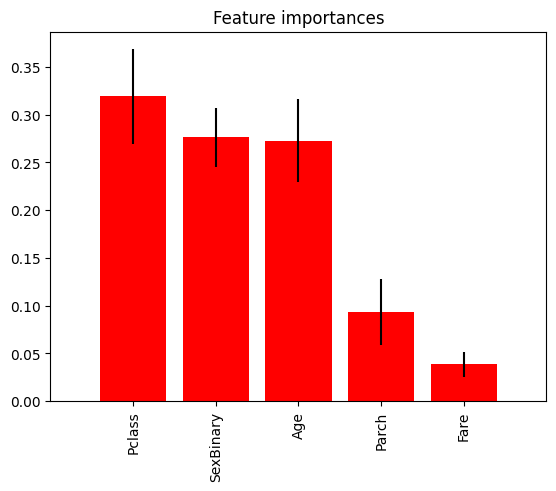

In [819]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
features = pd.Series(featuresModelRF)

# Print the feature ranking
print("Feature ranking:")

index_features=[]
for f in range(len(featuresModelRF)):
    index_features.append(f)
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], features[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(featuresModelRF)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(featuresModelRF)), features[index_features], rotation = 90)
plt.xlim([-1, len(featuresModelRF)])
plt.show()

uit de tabel kan je zien dat sex en Pclasse ontzettend veel mee draagt aan je overlevings kans. dit is natuurlijk ook logies want jongere mensen hebben meer vermogen en als je in de 1e klasse zit krijg je vaak voorang 

In [820]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import roc_auc_score

from sklearn.tree import plot_tree, export_graphviz

# 1. Load the test data
external_test_data = pd.read_csv('titanic/test.csv', sep=',')


def convert_sex(sex):
    return 1 if sex == 'male' else 0

# Convert Sex to binary
external_test_data['SexBinary'] = external_test_data['Sex'].apply(convert_sex)

# Corrected preprocessing step to avoid SettingWithCopyWarning
external_test_data = external_test_data.copy()

# Handle missing values or any other preprocessing done in training data

# 3. Prepare the features for prediction

X_testRF = external_test_data[featuresModelRF]

# Predict using Random Forest Model (Pclass, SexBinary, Age, Parch, Fare)
external_test_predictionsRF = forest.predict_proba(X_testRF)[:, 1]

print("Random Forest Model Predictions (Pclass, SexBinary, Age, Parch, Fare):")
print(external_test_predictionsRF[:10])  



Random Forest Model Predictions (Pclass, SexBinary, Age, Parch, Fare):
[0.115  0.2075 0.555  0.705  0.635  0.365  0.2775 0.075  0.86   0.045 ]


In [821]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import graphviz
from sklearn.metrics import roc_auc_score

from sklearn.tree import plot_tree, export_graphviz

# 1. Load the test data
external_test_data = pd.read_csv('titanic/test.csv', sep=',')


def convert_sex(sex):
    return 1 if sex == 'male' else 0

# Convert Sex to binary
external_test_data['SexBinary'] = external_test_data['Sex'].apply(convert_sex)

# Corrected preprocessing step to avoid SettingWithCopyWarning
external_test_data = external_test_data.copy()

X_testRF = external_test_data[featuresModelRF]

# Predict using Random Forest Model (Pclass, SexBinary, Age, Parch, Fare)
external_test_predictionsRF = forest.predict_proba(X_testRF)[:, 1]

print(external_test_predictionsRF[:10])  

[0.115  0.2075 0.555  0.705  0.635  0.365  0.2775 0.075  0.86   0.045 ]


AUC Score: 0.8935743965176097


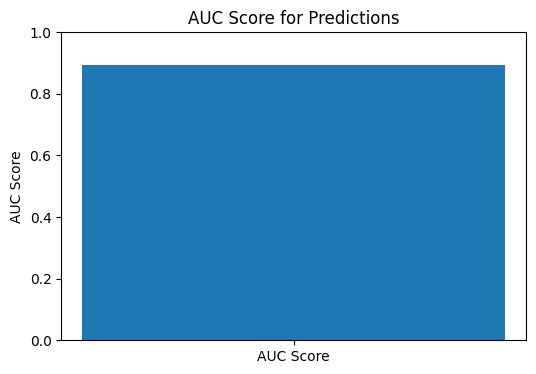

In [822]:
gender_submissions = pd.read_csv('titanic\gender_submission.csv', sep=',')

# Merge the true labels with predictions
# Assuming 'ID' is the common column to merge on
merged_data = pd.merge(external_test_data[['PassengerId']], gender_submissions, on='PassengerId', how='left')
merged_data['PredictedProb'] = external_test_predictionsRF

# Calculate AUC
true_labels = merged_data['Survived']
predicted_probs = merged_data['PredictedProb']
auc_score = roc_auc_score(true_labels, predicted_probs)

print(f"AUC Score: {auc_score}")

# Optionally, create a table with AUC score for visualization
import matplotlib.pyplot as plt

# You can visualize or save the AUC score if needed
plt.figure(figsize=(6, 4))
plt.bar(['AUC Score'], [auc_score])
plt.ylim([0, 1])
plt.ylabel('AUC Score')
plt.title('AUC Score for Predictions')
plt.show()